# Preliminary model for classification

This notebook aims to develop a preliminary version of a classifier for the challenge.

In [2]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import pickle

from tpot import TPOTClassifier

## Access processed data

In [3]:
DIR_REPO = Path.cwd().parent.parent
DIR_DATA_PROCESSED = Path(DIR_REPO) / "data" / "processed"
DIR_MODELS = Path(DIR_REPO) / "models"

os.listdir(DIR_DATA_PROCESSED)

['preprocessed_listings.csv']

In [4]:
FILEPATH_PROCESSED = DIR_DATA_PROCESSED / "preprocessed_listings.csv"

In [5]:
df = pd.read_csv(FILEPATH_PROCESSED, index_col=0)
df.head()

,id,neighbourhood,property_type,room_type,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
1,3831,Brooklyn,Entire guest suite,Entire home/apt,40.68494,-73.95765,3,1.0,1.0,3.0,75,0,1,0,1,1,1,1,0,0
3,5136,Brooklyn,Entire rental unit,Entire home/apt,40.66265,-73.99454,4,1.5,2.0,2.0,275,2,1,0,1,1,1,1,0,0
4,5178,Manhattan,Private room in rental unit,Private room,40.76457,-73.98317,2,1.0,1.0,1.0,68,0,1,0,1,0,1,1,0,0
5,5203,Manhattan,Private room in rental unit,Private room,40.80380,-73.96751,1,1.0,1.0,1.0,75,0,0,0,1,0,1,1,1,1
8,6872,Manhattan,Private room in condominium (condo),Private room,40.80107,-73.94255,1,1.0,1.0,1.0,65,0,0,0,0,1,1,1,1,0


## Convert string to categorical variable

In [6]:
# Categorical variable mapping dictionaries
MAP_ROOM_TYPE = {"Shared room": 1, "Private room": 2, "Entire home/apt": 3, "Hotel room": 4}
MAP_NEIGHB = {"Bronx": 1, "Queens": 2, "Staten Island": 3, "Brooklyn": 4, "Manhattan": 5}

In [7]:
MAP_PROPERTY_TYPE = {}
for i,pt in enumerate(list(df['property_type'].unique())):
    MAP_PROPERTY_TYPE.update({pt:i+1})

In [8]:
# Map categorical features
df["neighbourhood"] = df["neighbourhood"].map(MAP_NEIGHB)
df["room_type"] = df["room_type"].map(MAP_ROOM_TYPE)
df["property_type"] = df["property_type"].map(MAP_PROPERTY_TYPE)

In [9]:
df.head()

,id,neighbourhood,property_type,room_type,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
1,3831,4,1,3,40.68494,-73.95765,3,1.0,1.0,3.0,75,0,1,0,1,1,1,1,0,0
3,5136,4,2,3,40.66265,-73.99454,4,1.5,2.0,2.0,275,2,1,0,1,1,1,1,0,0
4,5178,5,3,2,40.76457,-73.98317,2,1.0,1.0,1.0,68,0,1,0,1,0,1,1,0,0
5,5203,5,3,2,40.80380,-73.96751,1,1.0,1.0,1.0,75,0,0,0,1,0,1,1,1,1
8,6872,5,4,2,40.80107,-73.94255,1,1.0,1.0,1.0,65,0,0,0,0,1,1,1,1,0


## Split data for cross-validation

In [11]:
FEATURE_NAMES = ['neighbourhood', 'property_type','room_type', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'TV', 'Internet', 'Air_conditioning', 'Kitchen', 'Heating',
       'Wifi', 'Elevator', 'Breakfast']

X = df[FEATURE_NAMES]
y = df['category']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

## A simple classifier model

In [150]:
pipeline_optimizer = TPOTClassifier()

In [151]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

In [152]:
pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6968669700888434

Generation 2 - Current best internal CV score: 0.6968669700888434

Generation 3 - Current best internal CV score: 0.698197087600421

Generation 4 - Current best internal CV score: 0.6988252255765424

Generation 5 - Current best internal CV score: 0.6988252255765424

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=2, min_samples_split=4, n_estimators=100)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

In [14]:
# Compute overall accuracy
print(pipeline_optimizer.score(X_test, y_test))

0.7155118275068034


### Evaluate the model

In [15]:
y_pred = pipeline_optimizer.predict(X_test)

In [16]:
# Compute overall accuracy
accuracy_score(y_test, y_pred)

0.7155118275068034

In [17]:
# Compute overall one-versus-rest area under the ROC

y_proba = pipeline_optimizer.predict_proba(X_test)
roc_auc_score(y_test, y_proba, multi_class='ovr')

0.8864857029448854

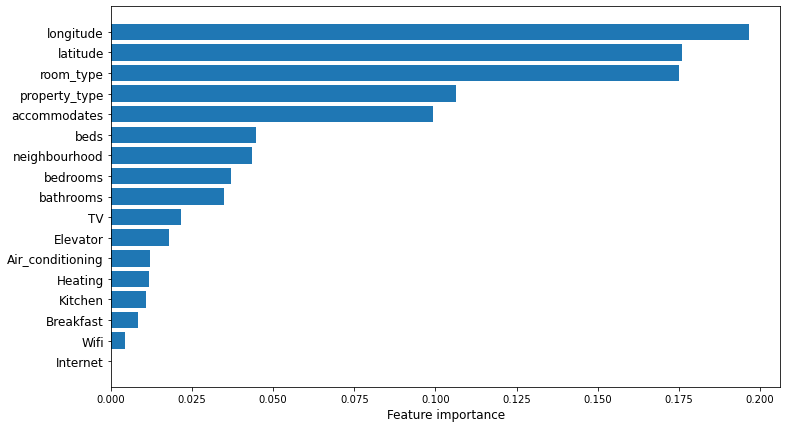

In [20]:
# importances = pipeline_optimizer.fitted_pipeline_['randomforestclassifier'].feature_importances_
importances = pipeline_optimizer.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]
importances = importances[indices]

fig, ax = plt.subplots(figsize=(12, 7))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), features, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Feature importance", fontsize=12)

plt.show()

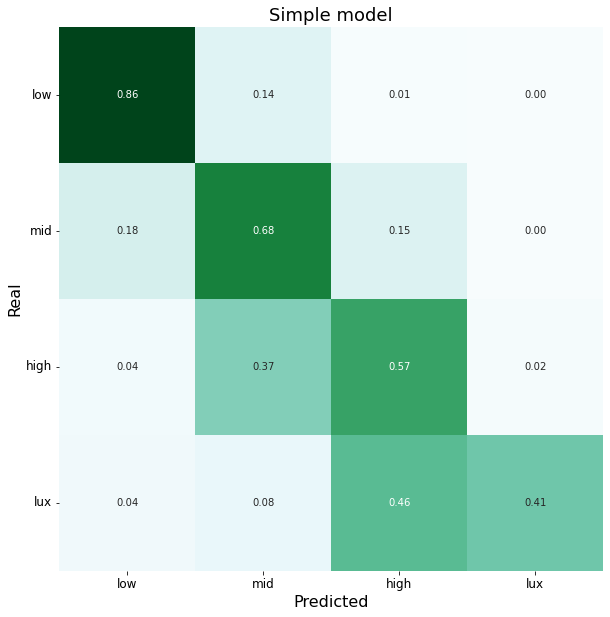

In [21]:
classes = [0, 1, 2, 3]
labels = ['low', 'mid', 'high', 'lux']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.title("Simple model", fontsize=18)

plt.show()

In [22]:
maps = {'0': 'low', '1': 'mid', '2': 'high', '3': 'lux'}

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame.from_dict(report).T[:-3]
df_report.index = [maps[i] for i in df_report.index]
df_report

,precision,recall,f1-score,support
low,0.836918,0.855317,0.846018,1956.0
mid,0.619459,0.677582,0.647218,1588.0
high,0.625806,0.570588,0.596923,1020.0
lux,0.783784,0.408451,0.537037,213.0


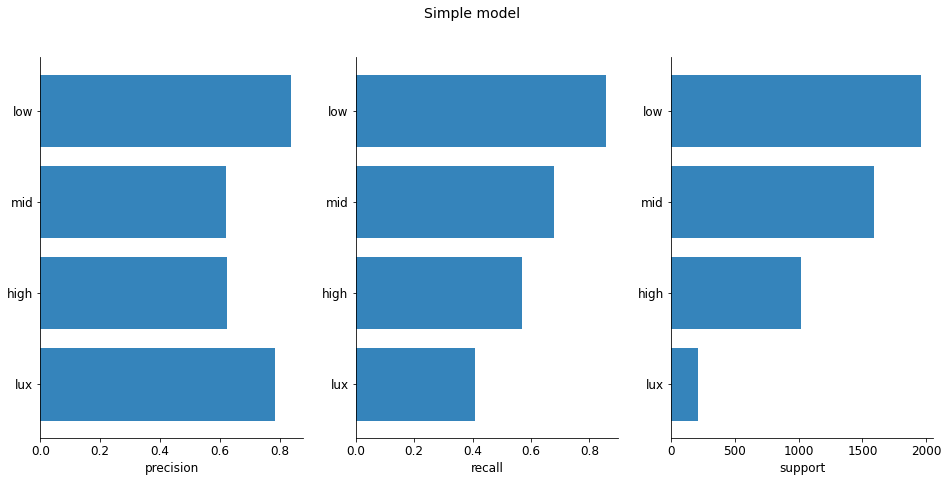

In [23]:
metrics = ['precision', 'recall', 'support']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 7))

for i, ax in enumerate(axes):

    ax.barh(df_report.index, df_report[metrics[i]], alpha=0.9)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(metrics[i], fontsize=12)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Simple model", fontsize=14)
plt.show()

In [180]:
pickle.dump(pipeline_optimizer.fitted_pipeline_['randomforestclassifier'], open(DIR_MODELS / "simple_classifier.pkl", 'wb'))

In [72]:
X_test

,neighbourhood,property_type,room_type,latitude,longitude,accommodates,bathrooms,bedrooms,beds,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
11038,4,3,2,40.71774,-73.94466,2,1.0,1.0,1.0,1,0,1,1,1,1,0,1
29233,4,3,2,40.71184,-73.95957,1,1.0,1.0,1.0,0,0,1,1,1,1,0,0
19905,2,3,2,40.65988,-73.77001,2,1.0,1.0,1.0,1,0,1,1,1,1,0,0
7699,5,3,2,40.80021,-73.96277,1,1.0,1.0,1.0,1,0,1,1,1,1,0,0
20694,5,8,2,40.80645,-73.95168,2,1.5,1.0,2.0,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22959,4,7,2,40.67981,-73.94382,2,2.0,1.0,1.0,1,0,1,1,1,1,0,0
35458,5,3,2,40.79563,-73.96461,1,2.0,1.0,1.0,1,0,1,1,0,1,0,0
14347,4,3,2,40.67333,-73.94769,1,1.0,1.0,1.0,1,0,1,1,1,1,0,0
24611,4,10,3,40.64873,-73.89826,4,1.0,2.0,2.0,1,0,1,1,1,1,0,0


In [76]:
dic_tmp = { "neighbourhood": 4,
            "property_type":2,
            "room_type": 3,
            "latitude": 40.71383,
            "longitude": -73.9658,
            "accommodates": 4,
            "bathrooms": 2,
            "bedrooms": 1,
            "beds": 2,
            "TV": 1,
            "Internet": 0,
            "Air_conditioning":0,
            "Kitchen":0,
            "Heating":0,
            "Wifi":0,
            "Elevator": 1,
            "Breakfast":0
    }

In [77]:
series = pd.Series(dic_tmp).values.reshape(1, -1)

In [78]:
tmp = pipeline_optimizer.predict(series)

D:\Anaconda\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [85]:
tmp[0]

2